In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Open Data

In [2]:
select_year = 2017
input = './data/out/%dpreprocess.csv.xz' % select_year
df = pd.read_csv(input, compression='xz')
#df.info()

## SnowballStemmer

In [3]:
stemmer = SnowballStemmer("english")
df['titulo'] = df['titulo'].map(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

## TF-IDF

In [4]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=.0025, max_df=.1, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df['titulo'])

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



,term,weight
849,learn,0.016822
1196,problem,0.015039
943,method,0.014558
1440,softwar,0.014497
423,detect,0.013654
540,evalu,0.013411
429,develop,0.012995
1199,process,0.012876
292,comput,0.012711
1077,optim,0.012554


In [5]:
print('vocabulary:', len(tfidf_vectorizer.vocabulary_))
print('sparse matrix shape:', tfidf.shape)
print('nonzero count:', tfidf.nnz)
print('sparsity: %.2f%%' % (100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

vocabulary: 1727
sparse matrix shape: (3055, 1727)
nonzero count: 47560
sparsity: 0.90%


## NMF

In [6]:
nmf = NMF(n_components=50, solver="mu")
W = nmf.fit_transform(tfidf)
H = nmf.components_

idx_to_word = np.array(tfidf_vectorizer.get_feature_names())
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: detect,classif,descriptor,video,spectral,imag use,automat,recognit,segment,imag
Topic 2: softwar engin,project,engin,softwar develop,softwar product,line,product line,product,develop,softwar
Topic 3: multi,neighborhood,schedul problem,search,rout problem,solv,schedul,rout,heurist,problem
Topic 4: communic,mechan,effici,improv perform,perform evalu,evalu,high,improv,parallel,perform
Topic 5: reinforc,deep,reinforc learn,learn approach,environ,learn object,machin learn,machin,learn environ,learn
Topic 6: number,databas,threshold,larg,convex,path,modal,color,edge,graph
Topic 7: rout,wireless network,underwat,network use,channel,sink,sensor network,wireless sensor,wireless,sensor
Topic 8: environ,big data,privaci,plan,big,secur,comput,cloud comput,servic,cloud
Topic 9: chang,plant,forest,environment,region,water,case studi,brazilian,case,brazil
Topic 10: map studi,requir,systemat review,systemat map,systemat literatur,map,literatur review,literatur,review,systemat
Topic 11: induct

In [7]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 10
feature_names = tfidf_vectorizer.get_feature_names()
display_topics(nmf,idx_to_word,no_top_words)


,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,...,Topic 45 words,Topic 45 weights,Topic 46 words,Topic 46 weights,Topic 47 words,Topic 47 weights,Topic 48 words,Topic 48 weights,Topic 49 words,Topic 49 weights
0,imag,2.631,softwar,2.236,problem,2.358,perform,1.919,learn,2.576,...,educ,2.556,mobil,2.111,industri,1.547,genom,1.355,architectur,2.564
1,segment,0.940,develop,1.103,heurist,0.476,parallel,0.634,learn environ,0.433,...,program,0.458,robot,1.184,augment,1.041,gene,1.100,refer architectur,0.326
2,recognit,0.526,product,0.757,rout,0.415,improv,0.562,machin,0.398,...,student,0.379,devic,0.549,realiti,0.894,sequenc,0.834,refer,0.324
3,automat,0.470,product line,0.625,schedul,0.407,high,0.455,machin learn,0.374,...,cours,0.353,mobil devic,0.485,augment realiti,0.805,cattl,0.579,embed,0.318
4,imag use,0.293,line,0.623,solv,0.381,evalu,0.413,learn object,0.352,...,distanc,0.337,support,0.410,brazilian,0.775,genom sequenc,0.548,devic,0.251
5,spectral,0.282,softwar product,0.579,rout problem,0.381,perform evalu,0.408,environ,0.270,...,open,0.301,cooper,0.347,automot,0.411,associ,0.519,constraint,0.246
6,video,0.277,softwar develop,0.567,search,0.360,improv perform,0.365,learn approach,0.254,...,technolog,0.282,mobil applic,0.315,research,0.405,identif,0.490,multiag,0.245
7,descriptor,0.276,engin,0.509,schedul problem,0.341,effici,0.363,reinforc learn,0.239,...,academ,0.262,mobil robot,0.296,experi,0.379,strain,0.473,reconfigur,0.209
8,classif,0.268,project,0.350,neighborhood,0.300,mechan,0.296,deep,0.226,...,teach,0.258,mobil cloud,0.282,track,0.327,wid,0.442,partial,0.207
9,detect,0.254,softwar engin,0.345,multi,0.284,communic,0.283,reinforc,0.222,...,robot,0.242,track,0.261,innov,0.309,genome wid,0.441,modular,0.190


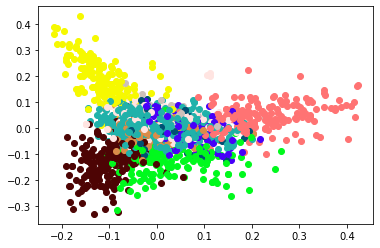

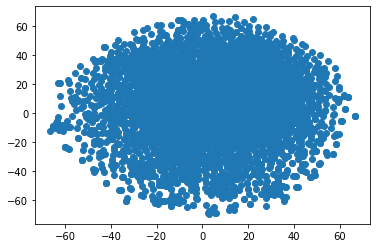

In [8]:
num_clusters = 10
num_seeds = 10
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tfidf)
#print(labels)

X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
#print(reduced_data)

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    #print(instance, index, labels[index])
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()